
# doc_model_uncertainty2.py


In [ ]:
# Installation des modules si besoin
pip install pandas matplotlib numpy lmfit openpyxl

Il s'agit tout d'abord de créer le dataframe vide avec les bons noms de colonnes qui sera rempli au fur et à mesure, mais qui ne doit pas se réinitialiser à chaque fois donc il faut le créer tout seul, hors du reste du code qui sera relancé à de multiples reprises

In [1]:
# Chargement packages et Creation du fichier pour les résultats finaux 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lmfit.models import GaussianModel

dframe_results_tot = pd.DataFrame(columns=['Echantillon','Centres (microns)','Proportion','Centres (phi)','Amplitude','Sigma'])

Ensuite on peut charger les données et indiquer que x sera toujours la même colonne.

In [2]:
# Charger les données
dframe = pd.read_csv('Decompo.csv')
x = dframe['Unites']

Ensuite on va indiquer le nom de l'échantillon en prenant dans dframe, ce sont tout simplement le nom des colonnes du decompo.csv

[[Model]]
    ((((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 886
    # data points      = 93
    # variables        = 15
    chi-square         = 0.11445816
    reduced chi-square = 0.00146741
    Akaike info crit   = -593.113521
    Bayesian info crit = -555.124529
    R-squared          = 0.99943298
[[Variables]]
    g1_amplitude:  0.82302788 +/- 0.24537395 (29.81%) (init = 1)
    g1_center:     2.22175022 +/- 0.03215553 (1.45%) (init = 2)
    g1_sigma:      0.36738700 +/- 0.03888226 (10.58%) (init = 1)
    g1_fwhm:       0.86513026 +/- 0.09156072 (10.58%) == '2.3548200*g1_sigma'
    g1_height:     0.89371871 +/- 0.17878801 (20.00%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  4.27698547 +/- 1.19297725 (27.89%) (init = 1)
    g2_center:     3.70213687 +/- 0.15569291 (4

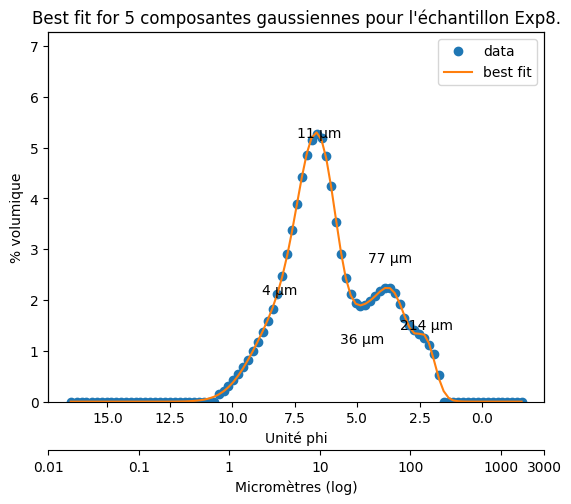

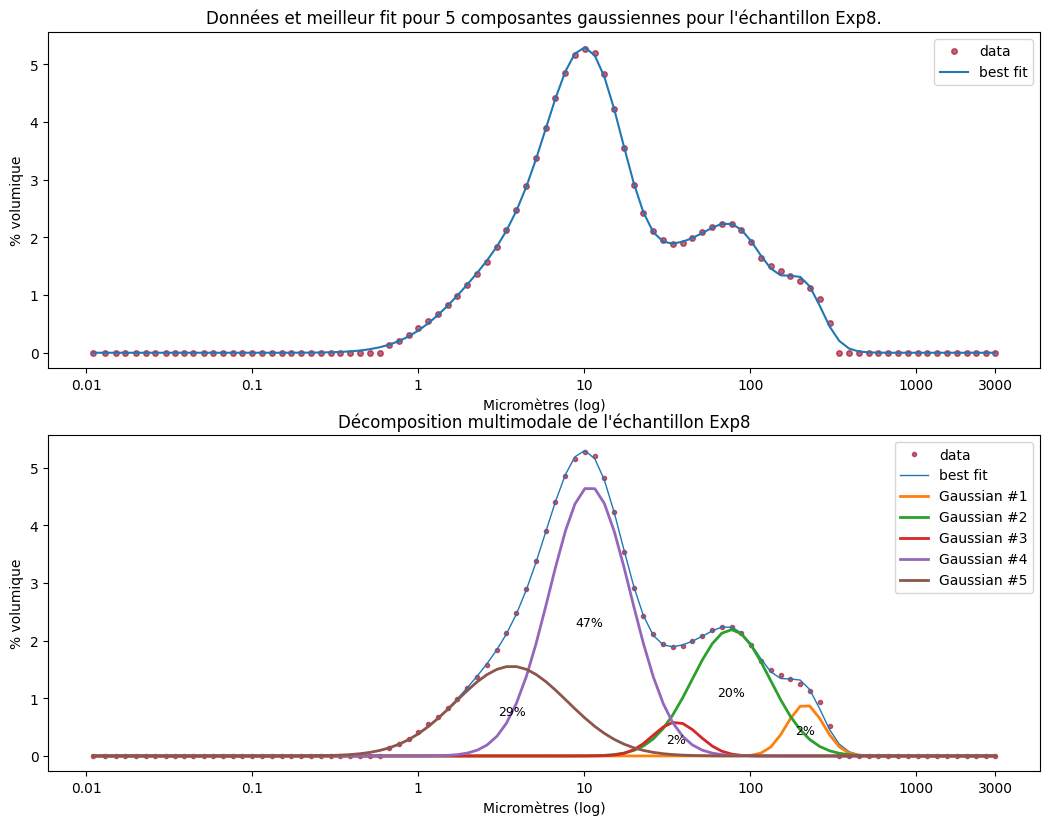

In [169]:
# Décomposition multimodale de distribution granulométrique
# Indiquer le nom de l'échantillon
echantillon = 'Exp8' 

# Choisir le nombre de composantes
centers_init = np.array([2,3,4,7,9])
sigmas_init = np.array([1,1,1,1,2])
amplitudes_init = np.array([1,1,1,1,1])

#############################################################
#############################################################
########## RIEN A MODIFIER NORMALEMENT EN DESSOUS ###########
#############################################################
#############################################################

num_components = len(centers_init)

# Fonction pour créer un modèle gaussien avec le nombre de composantes spécifié
def create_gaussian_model(num_components):
    model = None
    params = None

    for i in range(1, num_components + 1):
        # Crée une composante gaussienne avec un préfixe unique
        gauss = GaussianModel(prefix=f'g{i}_')
        
        # Si c'est la première composante, initialise le modèle et les paramètres
        if model is None:
            model = gauss
            params = gauss.make_params()
        else:
            # Sinon, ajoute cette composante au modèle existant
            model += gauss
            params.update(gauss.make_params())

        # Initialisation des paramètres pour chaque composante
        params[f'g{i}_center'].set(value = centers_init[i-1])
        params[f'g{i}_sigma'].set(value=sigmas_init[i-1])
        params[f'g{i}_amplitude'].set(value=amplitudes_init[i-1])
    
    return model, params

# Créer le modèle et les paramètres avec le nombre de composantes souhaité
model, params = create_gaussian_model(num_components)

# Ajustement
y = dframe[f'{echantillon}']
result = model.fit(y, params, x=x)
comps = result.eval_components(x=x)
centres_microns = []
centres_phi = []
sigmas = []
amplitudes = []

for i in range(1, num_components + 1):
    amplitude = result.params[f'g{i}_amplitude'].value
    centre = result.params[f'g{i}_center'].value
    sigma = result.params[f'g{i}_sigma'].value
    
      
    # Ajouter les paramètres dans les listes
    amplitudes.append(amplitude)
    sigmas.append(sigma)

# Affichage du rapport de l'ajustement
print(result.fit_report(min_correl=0.5))

# Création de la figure et de l'axe principal
fig, ax1 = plt.subplots()
result.plot_fit(ax=ax1)
ax1.invert_xaxis()

# Création d'un deuxième axe X sous le premier avec une échelle logarithmique
ax2 = ax1.twiny()  # Crée un nouvel axe X au-dessus
#ax2.set_xscale('log')  # Appliquer une échelle logarithmique
ax2.invert_xaxis()
# Positionner le second axe en bas
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 35))  # Déplacer l'axe vers le bas

# Synchroniser les limites des deux axes X
#ax2.set_xlim(ax1.get_xlim())

# Définir les valeurs des ticks en phi pour l'axe logarithmique en microns
custom_ticks = [-1.5849, 0, 3.3219, 6.6439, 9.9658, 13.2877, 16.6096]  # Les valeurs spécifiques que tu veux afficher sur l'axe log
ax2.set_xticks(custom_ticks)

# Définir les labels des ticks si nécessaire
custom_ticklabels = ['3000','1000', '100', '10', '1', '0.1', '0.01']
ax2.set_xticklabels(custom_ticklabels)

# Labels et titres
ax1.set_xlabel('Unité phi')
ax1.set_ylim([0, 2 + max(y)])
ax2.set_xlabel('Micromètres (log)')
ax1.set_ylabel('% volumique')
ax1.set_title(f'Best fit for {num_components} composantes gaussiennes pour l\'échantillon {echantillon}.')
# Ajouter la valeur centrale au-dessus du pic, sans décimale
for i in range(1, num_components + 1):
    centre_micron = 1000 * 2**(-result.params[f'g{i}_center'].value)
    centre_phi = result.params[f'g{i}_center'].value
    centres_microns.append(centre_micron)
    centres_phi.append(centre_phi)
    ax1.text(centre_phi, 0.5 + comps[f'g{i}_'][np.argmax(comps[f'g{i}_'])],  # Un peu plus haut que la proportion
                f'{centre_micron:.0f} µm',  # Afficher la valeur centrale sans décimale
                horizontalalignment='center', 
                verticalalignment='bottom', 
                fontsize=10, 
                color='black')
                
# Afficher le graphique du fit général
plt.show()

# Fonction pour créer un modèle gaussien avec le nombre de composantes spécifié
total_area = 0
areas = []
for i in range(1, num_components + 1):
    area = result.params[f'g{i}_amplitude'].value * np.sqrt(2 * np.pi) * result.params[f'g{i}_sigma'].value
    areas.append(area)
    total_area += area

# Calcul de la proportion des composantes
# L'aire sous une gaussienne est donnée par amplitude * sqrt(2 * pi) * sigma

# Proportion de chaque gaussienne
proportions = []
for i in range(num_components):
    proportion = areas[i] / total_area
    proportions.append(proportion)

## Graphiques
fig, axes = plt.subplots(2, 1, figsize=(12.8, 9.6))

axes[0].plot(x, y, 'o', color='#99002299', markersize=4, label='data')
axes[0].plot(x, result.best_fit, '-', label='best fit')
axes[0].invert_xaxis()
axes[0].set_title(f'Données et meilleur fit pour {num_components} composantes gaussiennes pour l\'échantillon {echantillon}.')
axes[0].legend()
axes[0].set_xticks(custom_ticks)
axes[0].set_xticklabels(custom_ticklabels)
axes[0].set_xlabel('Micromètres (log)')
axes[0].set_ylabel('% volumique')

axes[1].plot(x, y, 'o', color='#99002299', markersize=3, label='data')
axes[1].plot(x, result.best_fit, '-', label='best fit',linewidth=1)

for i in range(1, num_components + 1):
    label = f'Gaussian #{i}'  # Générer un label pour chaque gaussienne
    axes[1].plot(x, comps[f'g{i}_'], label=label, linewidth=2)

    # Calculer la position du texte pour la proportion
    # On peut utiliser le centre de la gaussienne comme position
    center = result.params[f'g{i}_center'].value  # Centre de la gaussienne
    proportion = proportions[i-1] * 100  # Convertir en pourcentage

    # Placer le texte à une position proche du centre de la gaussienne
    axes[1].text(center, 0.5 * comps[f'g{i}_'][np.argmax(comps[f'g{i}_'])],  # Ajuster la hauteur
                  f'{proportion:.0f}%', 
                  horizontalalignment='center', 
                  verticalalignment='center', 
                  fontsize=9) 
                  #bbox=dict(facecolor='white', alpha=0.5))

axes[1].invert_xaxis()
axes[1].set_title(f'Décomposition multimodale de l\'échantillon {echantillon}')
axes[1].legend()
axes[1].set_xticks(custom_ticks)
axes[1].set_xticklabels(custom_ticklabels)
axes[1].set_xlabel('Micromètres (log)')
axes[1].set_ylabel('% volumique')

plt.show()

dframe_results = pd.DataFrame({
    'Echantillon': echantillon,
    'Centres (microns)': centres_microns,
    'Proportion': proportions,
    'Centres (phi)': centres_phi,
    'Amplitude': amplitudes,
    'Sigma': sigmas    
})

dframe_results.loc[1:,'Echantillon'] = None

#print(dframe_results)





Et une fois qu'on est content avec la décomposition de cet échantillon, on lance le code ci-dessous pour **exporter les graphiques**, et **ajouter les résultats** de cet échantillon aux résultats globaux de la série.

In [170]:
# Export des graphiques et création du fichier général 
fig.savefig(f'graphique_resultat{echantillon}.pdf', format='pdf', bbox_inches='tight', dpi=300)

dframe_results_tot = pd.concat([dframe_results_tot, dframe_results])


Et **tout à la fin on exporte les résultats**

In [171]:
# Export du fichier final de données

dframe_results_tot.to_excel('Résultats décomposition.xlsx', index = False)